In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import DBSCAN

import seaborn.apionly as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')

from ipywidgets import IntSlider, interact

%load_ext autoreload
%autoreload 2

# Clustering the whole dataset

In this 3rd notebook, we will divide the whole dataset of mRNA and proteins levels into various clusters, hoping to find a cluster of uncorrelated entries.<br/>
We will proceed in 3 parts :
- First of all, we will keep analysing our dataset with various clusterisations using k-Means
- Then, we will study the correlation between mRNA and proteins levels within each cluster
- Finally, we will do the same for another clustering methods : Ward (Agglomerative Hierarchical clustering)

### Loading data

In [2]:
# Standardized data
prot_data = pd.read_csv('data/data_prot_norm.csv', index_col=0, header=[0, 1])
mRNA_data = pd.read_csv('data/data_mRNA_norm.csv', index_col=0, header=[0, 1])
data = pd.read_csv('data/data_norm.csv', index_col=0, header=[0, 1])

## I - K-means and clusters analysis

In this first part, we divide our data into clusters using the k-Means method.
- In order to get an idea of the behavior of our mRNA and proteins, we will first cluster them independently
- Then, we will cluster each entry (including mRNA and proteins levels) for several values of k

### a) Functions definition

Let's define a function to learn the model :

In [3]:
def kmeans(df, k):
    kmeans_model = KMeans(n_clusters=k)
    model = kmeans_model.fit(df)
    score = silhouette_score(df, model.labels_)
    return model, score

Now, we define 3 other plot functions in order to visualize our results :
- The first plots the mean of each cluster over time
- The second plots the levels of mRNA & proteins for one cluster particular cluster
- The third plots the avergared levels of mRNA & proteins over time for one cluster particular cluster

In [4]:
def plot_kmeans_centers(model, n_clust, pos=plt):
    
    for k in range(n_clust):
        pos.plot(model.cluster_centers_[k,:], label='c'+str(k))
    
    pos.legend(loc='best')

In [5]:
def plot_clust(model, df1, df2, l, pos = plt):
    pos.plot(np.arange(10), df1.iloc[np.where(model.labels_==l)].values.T, color=(1.0,0.0,0.0,0.1))
    pos.plot(np.arange(10), df2.iloc[np.where(model.labels_==l)].values.T, color=(0.0,0.0,1.0,0.1))
    
    red = mpatches.Patch(color='red', label='prot')
    blue = mpatches.Patch(color='blue', label='mRNA')
    pos.legend(handles=[red,blue], loc='best')

In [6]:
def plot_clust_avg(model, df1, df2, l, pos = plt):
    pos.plot(pd.DataFrame(df1.iloc[np.where(model.labels_==l)].values).mean(), label = "protein")
    pos.plot(pd.DataFrame(df2.iloc[np.where(model.labels_==l)].values).mean(), label = "mRNA")
    
    pos.legend(loc='best')

### b) Proteins clustering

We choose k=2 clusters as it gives the best silhouette score :

silhouette score = 0.48028871213


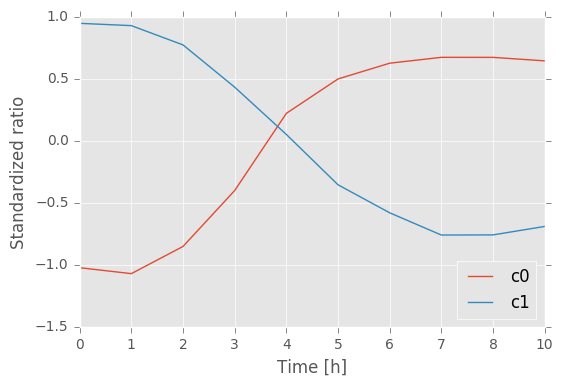

1397 entries in cluster 0
1448 entries in cluster 1


In [7]:
# Use k-means clustering with 'n_clust' clusters
n_clust = 2
prot_model, prot_score = kmeans(prot_data, n_clust)

# Display results of k-means
print('silhouette score =', prot_score)
plot_kmeans_centers(prot_model, n_clust)
plt.xlabel('Time [h]')
plt.xticks([k for k in range(0,10)], [k for k in range(0,11) if k != 9])
plt.ylabel('Standardized ratio')
plt.show()

for l in range(n_clust):
    n_entries = np.sum(prot_model.labels_ == l)
    print(str(n_entries)+' entries in cluster '+str(l))

The proteins levels can be divided into 2 balanced clusters : those which descrease and those which increase over time.

### c) mRNA clustering

We choose k=3 clusters as it gives the best silhouette score :

silhouette score = 0.307127384358


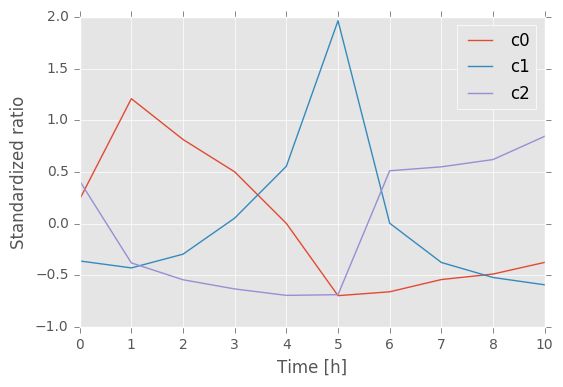

1059 entries in cluster 0
930 entries in cluster 1
856 entries in cluster 2


In [8]:
# Use k-means clustering with 'n_clust' clusters
n_clust = 3
mRNA_model, mRNA_score = kmeans(mRNA_data, n_clust)

# Display results of k-means
print('silhouette score =', mRNA_score)
plot_kmeans_centers(mRNA_model, n_clust)
plt.xlabel('Time [h]')
plt.xticks([k for k in range(0,10)], [k for k in range(0,11) if k != 9])
plt.ylabel('Standardized ratio')
plt.show()

for l in range(n_clust):
    n_entries = np.sum(mRNA_model.labels_ == l)
    print(str(n_entries)+' entries in cluster '+str(l))

The mRNA levels can be divided into 3 balanced clusters : 
- Cluster 0's levels increase between 0h and 1h, decrease until 5h, and increase weakly until 10h
- Cluster 1's levels reach a peak at 5h
- Cluster 2's levels decrease betweeen 0h and 5h (but more weakly between 1h and 5h), increashe between 5h and 9h (with a distinct rise between 5h and 6h) 

### d) Clustering mRNA and proteins pairs

We clustered proteins and their associated mRNA using 2 datasets :
- The original dataset, with 10 time points for mRNA and 10 time points for proteins.
- A new dataset containing relative distance between mRNA and protein levels for the 10 time points.

#### 1) Using the original dataset

We learn the model for several values of k :

In [7]:
data_model, data_score = {}, {}

k = [2, 3, 4, 5, 10, 20, 30, 40, 50]

for n_clust in k:
    data_model[n_clust], data_score[n_clust] = kmeans(data, n_clust)

And observe the resulting scores :

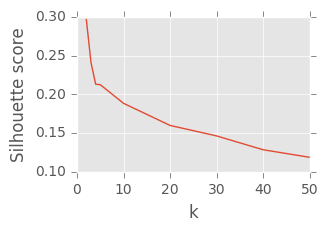

In [8]:
scores = pd.Series(data_score, name='Score')
scores.index.name = 'k'

plt.figure(figsize=(3,2))
plt.plot(scores, )
plt.xlabel('k')
plt.ylabel("Silhouette score")

When the number of clusters increases, the silhouette score lowers. <br/>
Low values (near 0) indicates overlapping clusters.

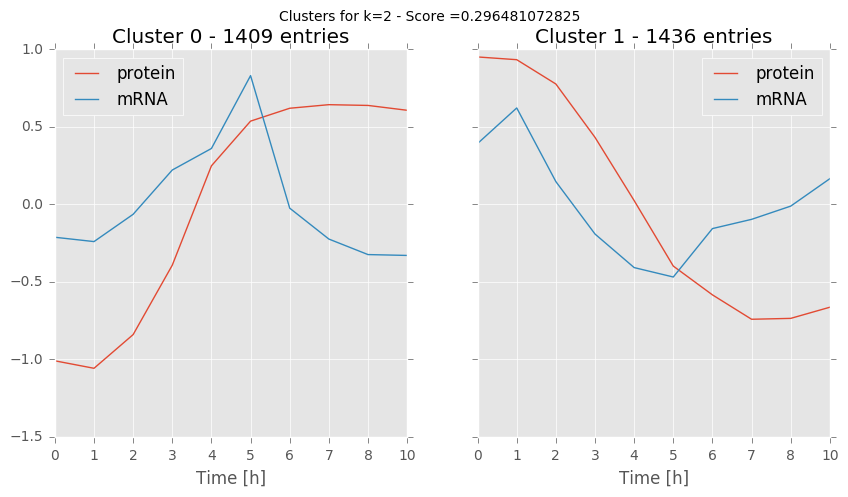

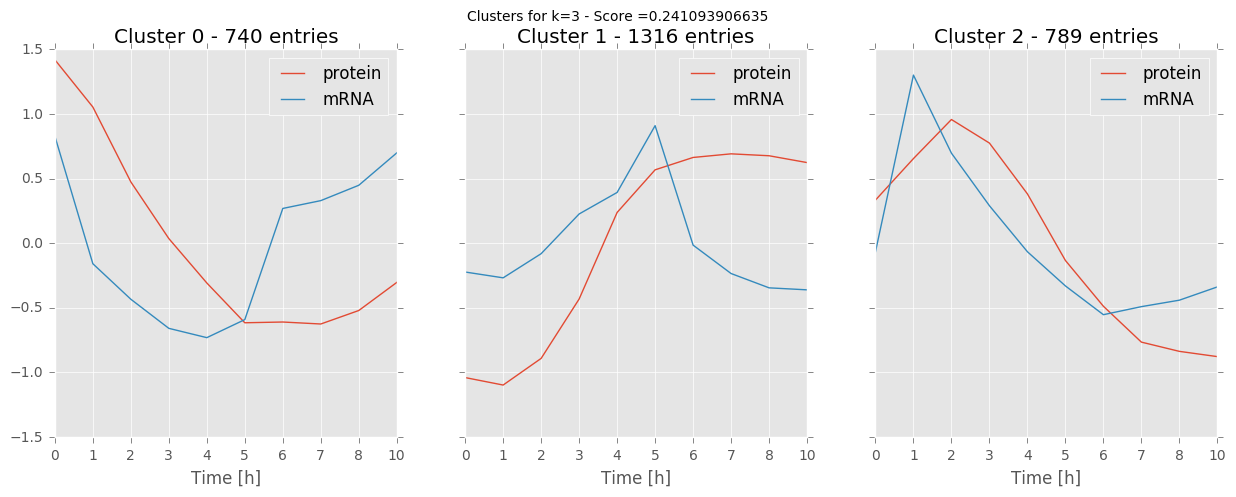

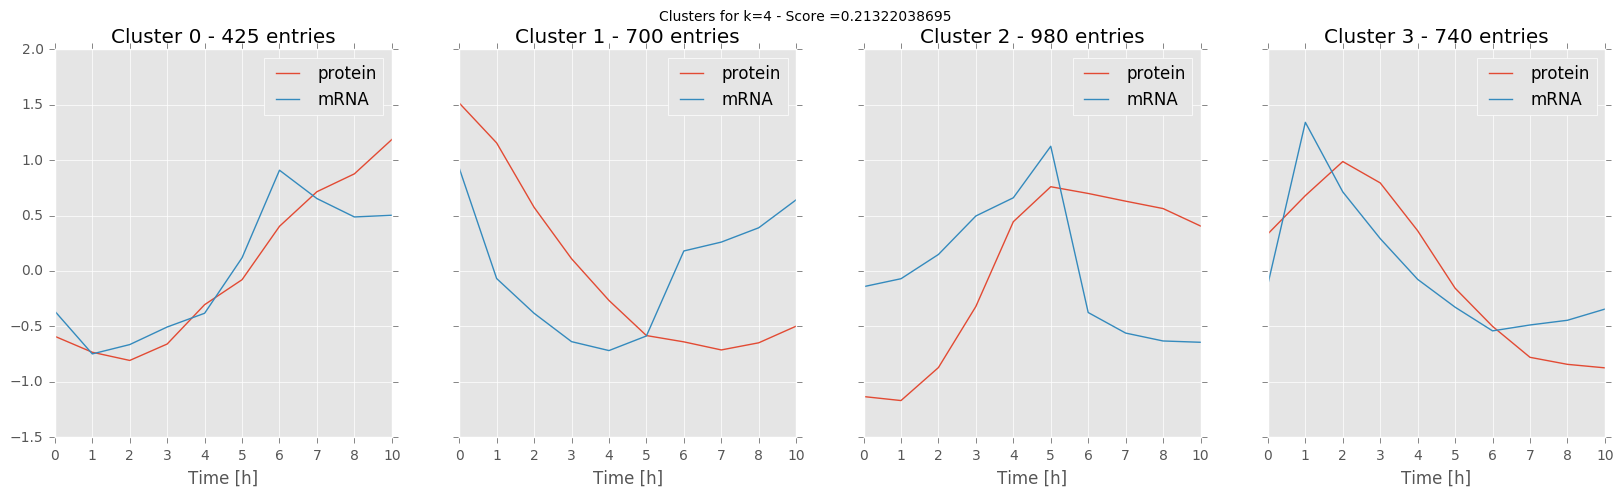

In [9]:
for n_clust in [2, 3, 4]:
        
    f, axarr = plt.subplots(1,n_clust, figsize=(5*n_clust,5), sharey=True)
    f.suptitle('Clusters for k='+str(n_clust)+' - Score ='+str(data_score[n_clust]))

    for k in range(n_clust):
        axarr[k].plot(data_model[n_clust].cluster_centers_[k,0:10], label = "protein")
        axarr[k].plot(data_model[n_clust].cluster_centers_[k,10:20], label = "mRNA")
        axarr[k].set_title('Cluster '+str(k)+' - '+str(np.sum(data_model[n_clust].labels_ == k))+' entries')
        axarr[k].legend(loc='best')
        axarr[k].set_xticklabels([k for k in range(0, 11) if k!= 9])
        axarr[k].set_xlabel('Time [h]')

    plt.show()

Let's analyse our clusters :

For k = 2 balanced clusters :
- The 1st cluster (0) combines ascending mRNA levels until t5, and descending until t9 and ascending protein levels.<br/>
It can be view as the result of regulatory processes (post-transcriptionnal)
- The 2nd cluster (1) combines descending mRNA levels until t5, and ascending until t9 - and descending protein levels until t7, and weakly ascending until t9

As we observed in our previous notebook, the levels seem to stop being correlated after t5.

For k = 3 clusters :
- We find our 2 previous clusters again, counting a similar number of entries : 
    - Cluster 0 = previous cluster 1 (with descending levels until t5)
    - Cluster 1 = previous cluster 0 (with the protein level peak at t5)
- Cluster 2 counts more entries and show a correlation between mRNA level at time = t and protein level at time = t+1.

For k = 4 clusters :
- We find our 3 previous clusters again
    - Cluster 1 = previous cluster 0
    - Cluster 2 = previous cluster 1 
    - Cluster 3 = previous cluster 2 
- Our new cluster (cluster 0) shows correlated levels between t0 and t6

#### 2) Using the relative distance

We now try to find clusters using the relative distance :

In [10]:
rel_dist_data = (mRNA_data["mRNA"] - prot_data["prot"]).copy()
rel_dist_data.head()

h0        h1        h2        h3        h4        h5  \
SPAC1002.02   0.213553  1.445473  1.481160  0.815101 -1.503567 -1.518788   
SPAC1002.03c -2.091111 -2.287418 -0.604456  0.049110  0.644065  2.199217   
SPAC1002.04c -1.227912 -1.163256 -1.027578 -0.657646 -0.529099  0.854056   
SPAC1002.07c  1.021758  1.817228  1.587298  1.179104  0.339370  0.261515   
SPAC1002.09c -0.995467  0.774053  3.382809  2.510578  0.627488 -0.427266   

                    h6        h7        h8       h10  
SPAC1002.02  -0.710336 -0.190958 -0.095742  0.064103  
SPAC1002.03c  1.722939 -0.166886 -0.341873  0.876412  
SPAC1002.04c  0.640567  1.332763  1.240310  0.537795  
SPAC1002.07c -1.814068 -1.590526 -1.472448 -1.329232  
SPAC1002.09c -0.823372 -1.073153 -1.432994 -2.542678

We learn the model for several values of k :

In [11]:
rel_dist_model, rel_dist_score = {}, {}

k = [2, 3, 4, 5, 10, 20, 30, 40, 50]

for n_clust in k:
    rel_dist_model[n_clust], rel_dist_score[n_clust] = kmeans(rel_dist_data, n_clust)

Again, when the number of clusters increases, the silhouette score lowers.<br/>
Let's plot the clusters :

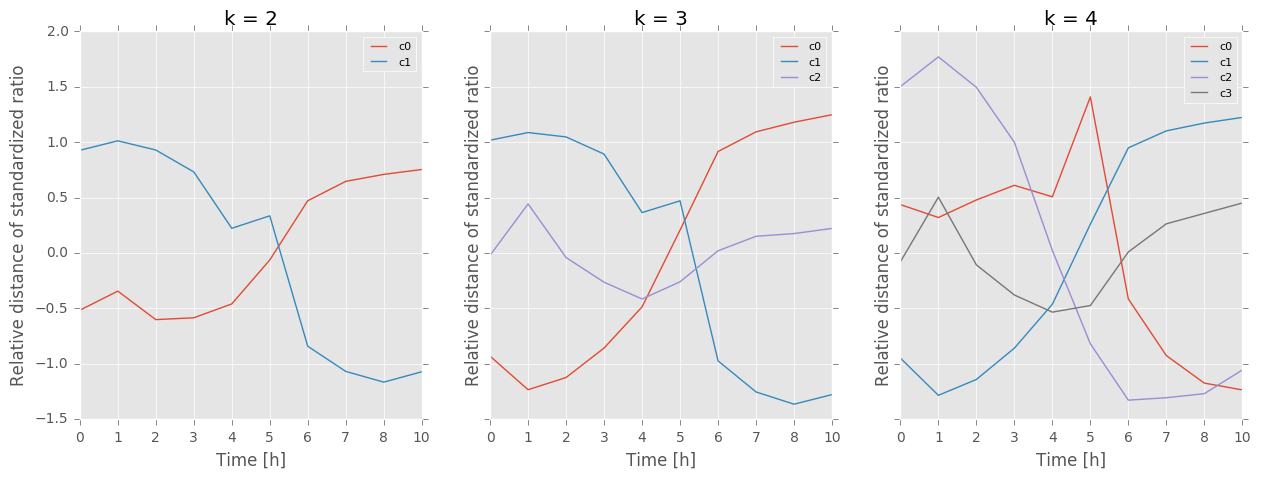

In [12]:
f, axarr = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for n_clust in [2, 3, 4]:

    #print('k = {} - silhouette score = {}'.format(n_clust, rel_dist_score[n_clust]))
    plot_kmeans_centers(rel_dist_model[n_clust], n_clust, pos=axarr[n_clust-2])
    axarr[n_clust-2].legend(loc='best', fontsize=8)
    axarr[n_clust-2].set_xlabel('Time [h]')
    axarr[n_clust-2].set_ylabel('Relative distance of standardized ratio')
    axarr[n_clust-2].set_title("k = "+str(n_clust))
    axarr[n_clust-2].set_xticklabels([k for k in range(0, 11) if k!= 9])

plt.show()

Remembre that our relative distance represents *protein levels - mRNA level*.<br/>
As an example, for k = 2 : 
- Cluster 0 (red) indicates a descending protein level, or an ascending mRNA level, or both of them.
- Cluster 1 (blue) indicates a descending mRNA level, or an ascending protein level, or both of them.

In order to visualize the real distribution of the data, we can plot each entry :

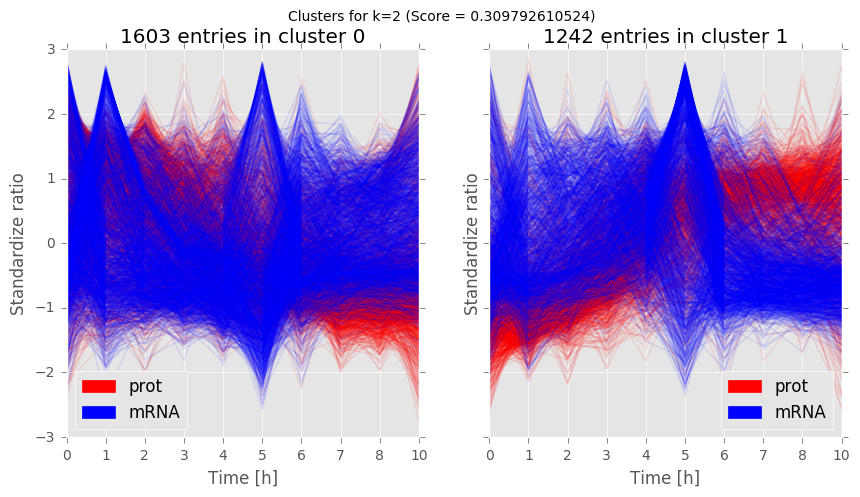

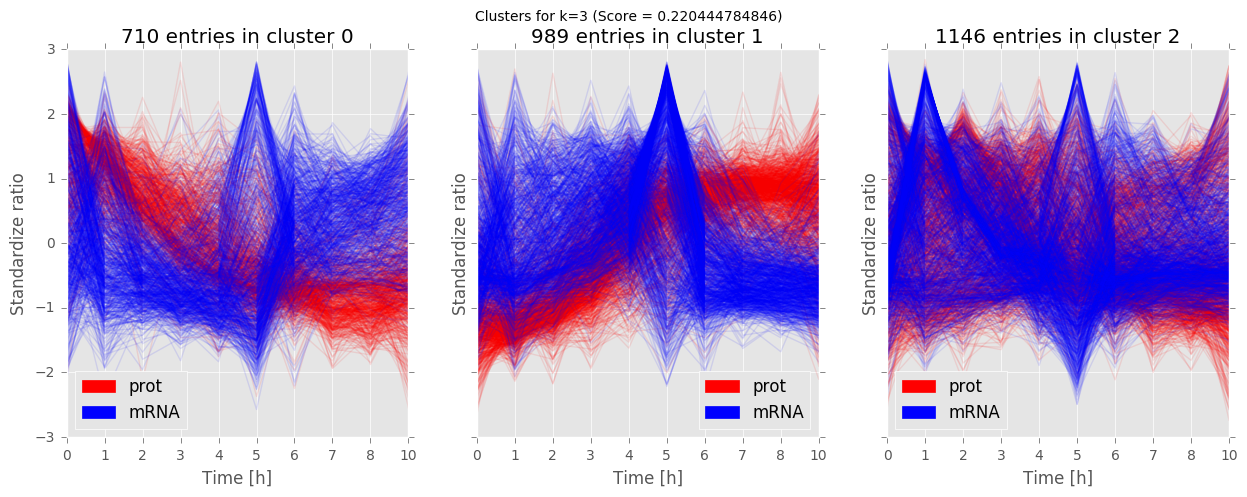

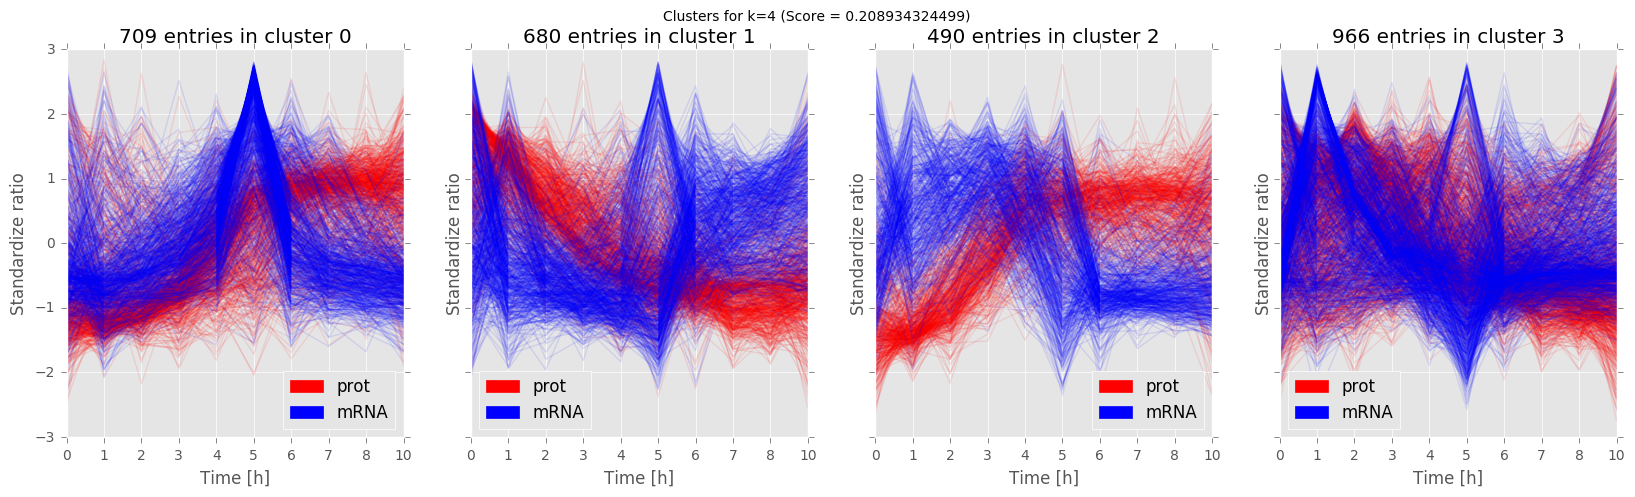

In [13]:
for n_clust in [2, 3, 4]:
        
    f, axarr = plt.subplots(1,n_clust, figsize=(5*n_clust,5), sharey=True)
    f.suptitle('Clusters for k='+str(n_clust)+' (Score = '+str(rel_dist_score[n_clust])+')')
    
    for k in range(n_clust):
        plot_clust(rel_dist_model[n_clust], prot_data, mRNA_data, k, pos = axarr[k])

        n_entries = np.sum(rel_dist_model[n_clust].labels_ == k)
        axarr[k].set_title(str(n_entries)+' entries in cluster '+str(k))
        axarr[k].set_ylabel('Standardize ratio')
        axarr[k].set_xlabel('Time [h]')
        axarr[k].set_xticklabels([k for k in range(0, 11) if k!= 9])

    plt.show()

We find in c2 and c3 interesting patterns of anti-correlations in c0, c1 and c2.

## II - Correlation between mRNA and proteins level within cluters

Now, it's time to check if we can get some clusters of uncorrelated entries.<br/>
We will study the models based on the relative distance between levels as it gives betters results.

In [14]:
def compute_corr(k):
    return prot_data.iloc[k]["prot"].corr(mRNA_data.iloc[k]["mRNA"], method='pearson')

We compute the correlation between protein and mRNA levels for each entry of each cluster for our various models.

In [15]:
k = [2, 3, 4, 5, 10, 20, 30, 40, 50]
corr_models = {}

for n_clust in k: # For each model with various k
    corr_clust = []
    for l in range(rel_dist_model[n_clust].labels_.max()+1): # For each cluster in this model
        correl = np.array([])
        for x in np.where(rel_dist_model[n_clust].labels_ == l)[0]: # For each entry corresponding to this cluster
            correl = np.append(correl, [compute_corr(x)])
        
        corr_clust.append(pd.Series(correl, index=data.index[np.where(rel_dist_model[n_clust].labels_ == l)]))
        
    corr_models[n_clust] = corr_clust

Let's plot it :

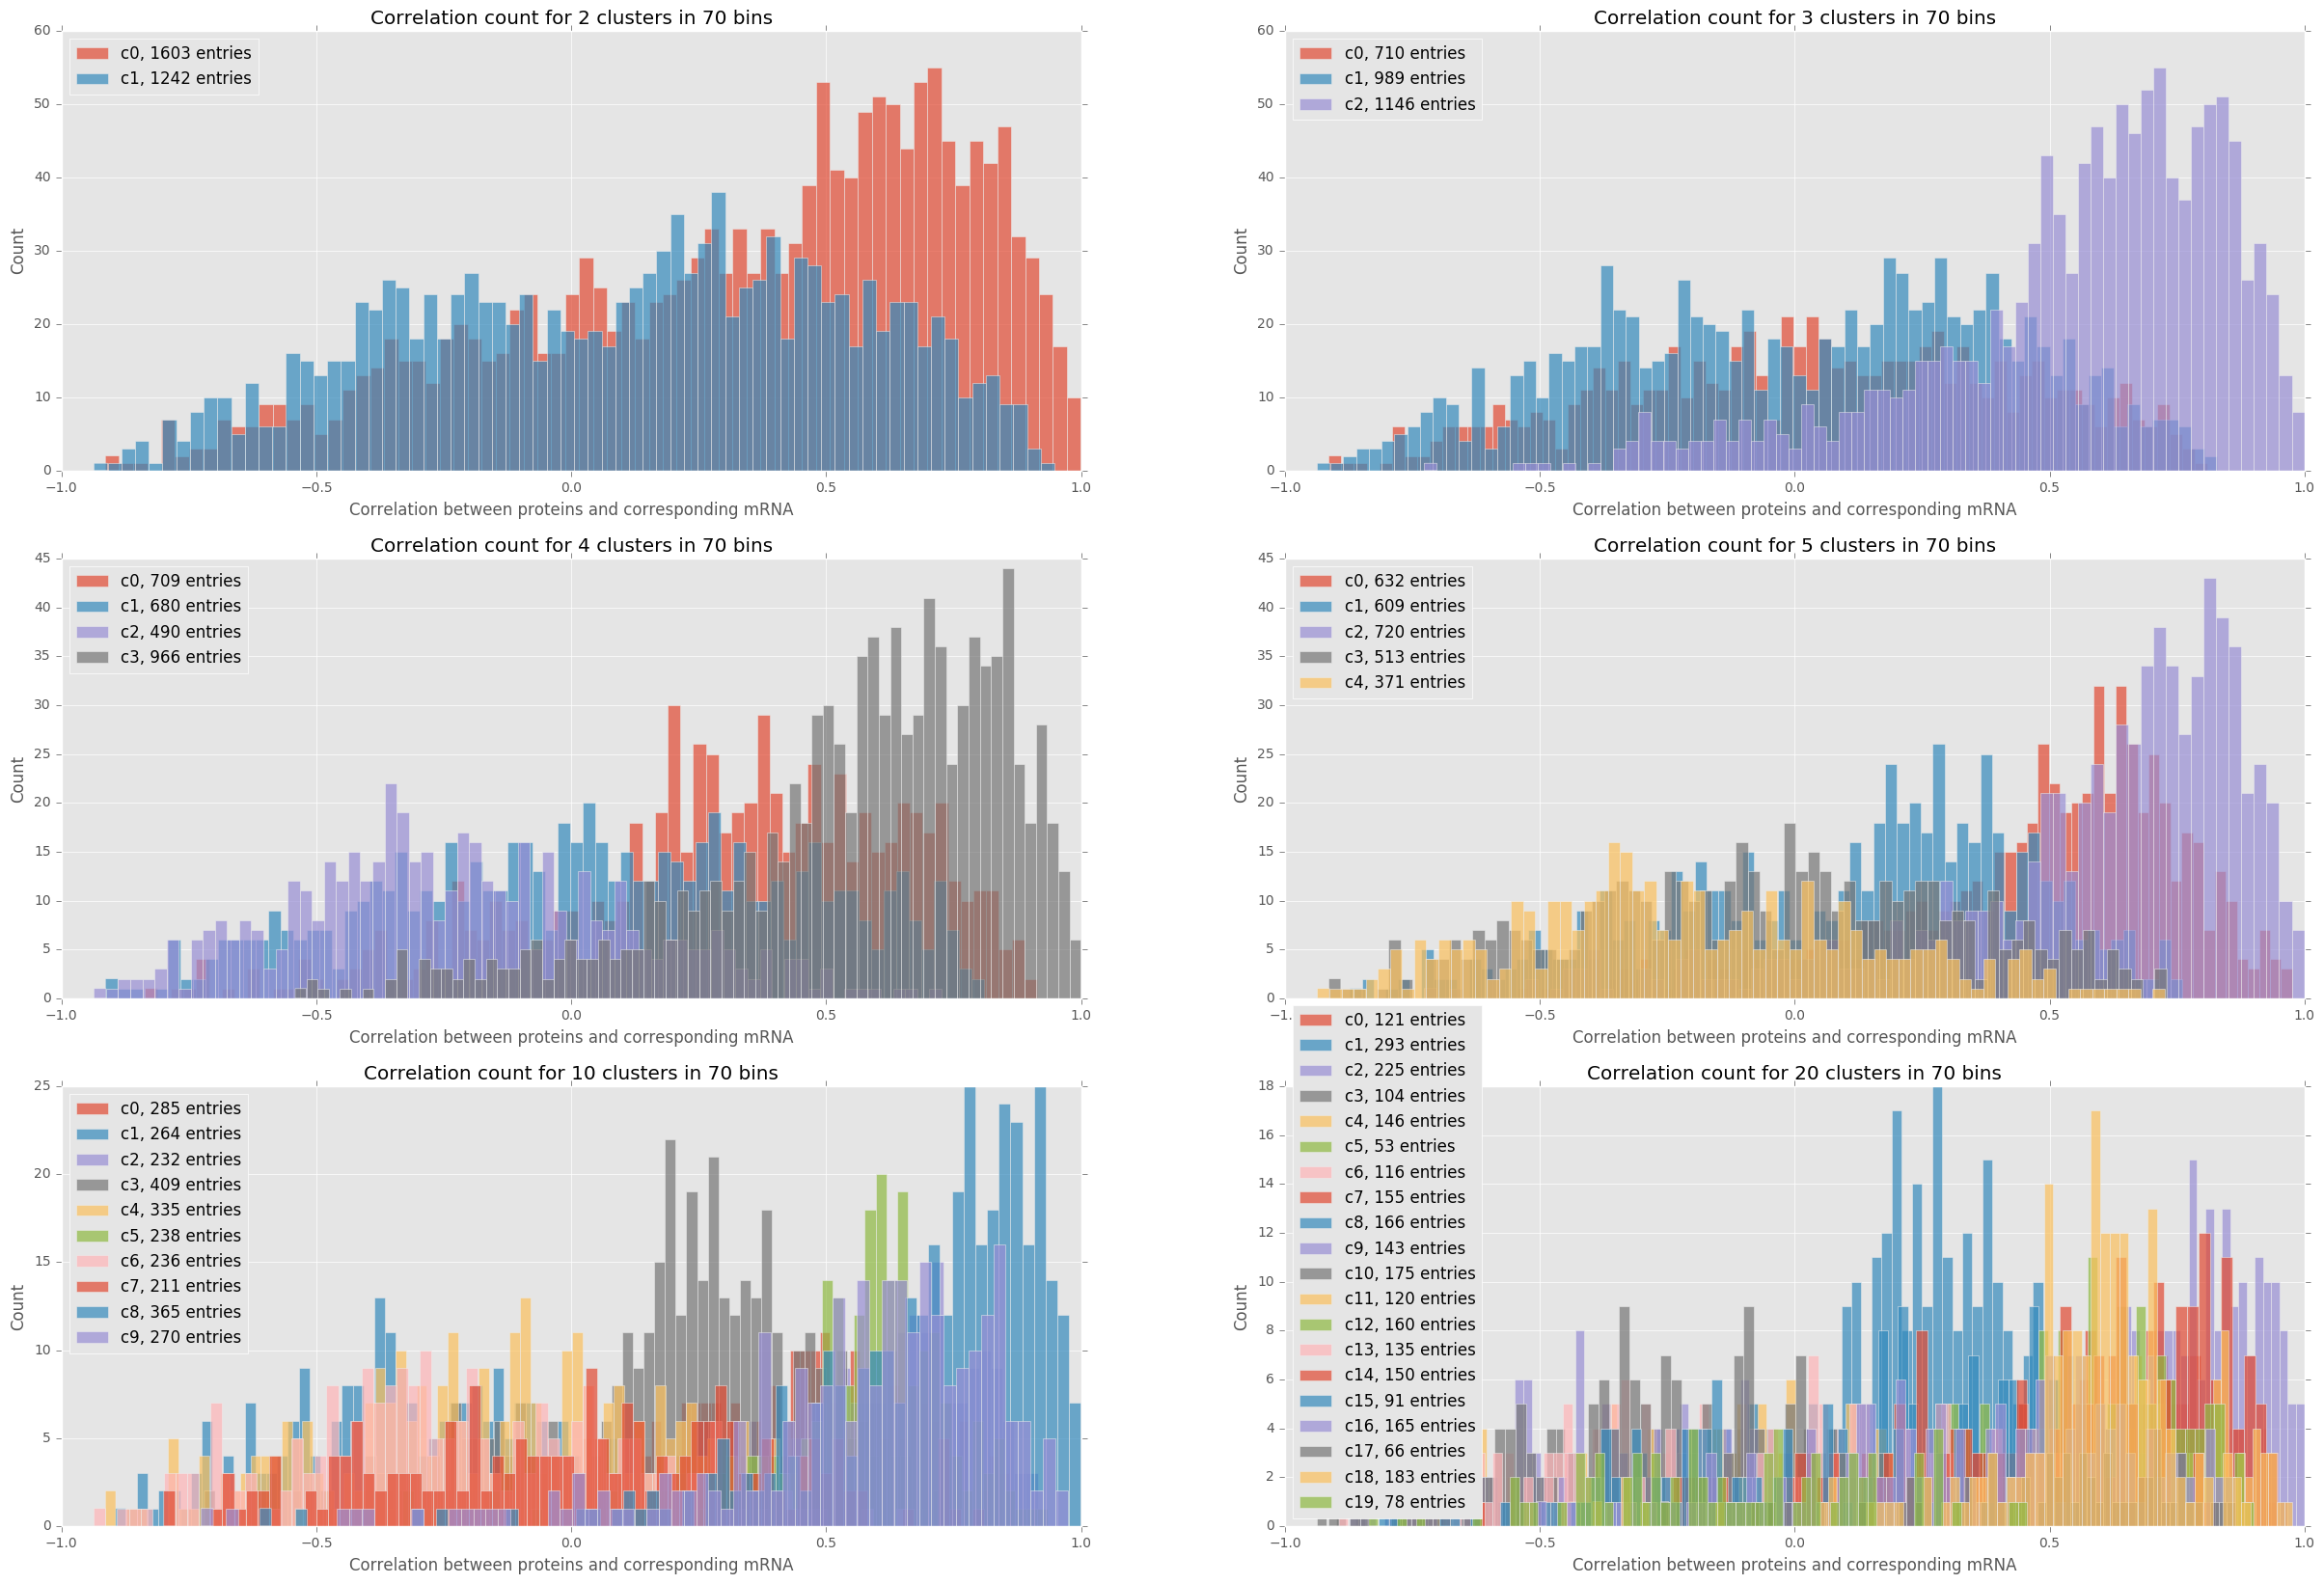

In [16]:
nbins = 70

k_values = [2, 3, 4, 5, 10, 20]
f, axarr = plt.subplots(3,2, figsize=(30,20))

for it, k_model in enumerate(k_values):
    x = it // 2
    y = it % 2
    
    for k in range(k_model):
        axarr[x,y].hist(corr_models[k_model][k], bins=nbins, label='c'+str(k)+', '+str(len(corr_models[k_model][k]))+' entries', 
                        alpha=0.7)
    axarr[x,y].legend(loc='best')
    axarr[x,y].set_title('Correlation count for '+str(k_model)+' clusters in '+str(nbins)+' bins')
    axarr[x,y].set_xlabel('Correlation between proteins and corresponding mRNA')
    axarr[x,y].set_ylabel('Count')

plt.show()

We can make some general observations :
- The repartion into clusters and the levels correlations are linked
- Increasing the number of clusters doesn't enable to create clusters of "correlation"

For k = 4 :
- c3 contains correlated entries (*averaged corr = 0.56*)
- c0 contains more weakly correlated entries (*averaged corr = 0.3*)
- c1 contains mostly uncorrelated entries (*averaged corr = 0.04*)
- c2 contains rather anti-correlated entries (*averaged corr = -0.22*)

## III -  Hierarchical clustering (ward)

First, we define a function enabling to fit the model :

In [17]:
def hierarchical_clustering(X, n_clust):
    return AgglomerativeClustering(n_clusters=n_clust, linkage='ward').fit(X)

Then we learn the model for several numbers of clusters (k) :

In [18]:
ward_model = {}

k = [2, 3, 4, 5, 10, 20]

for n_clust in k:
    ward_model[n_clust] = hierarchical_clustering(rel_dist_data, n_clust)

Finally, we plot the results :

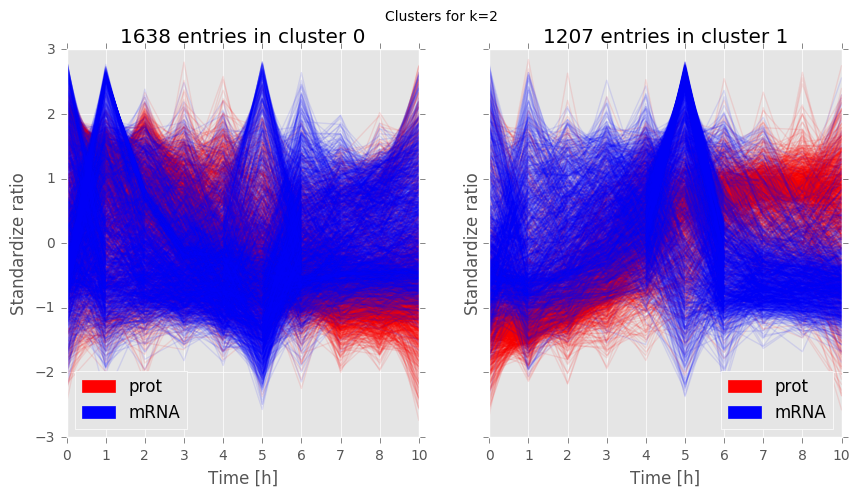

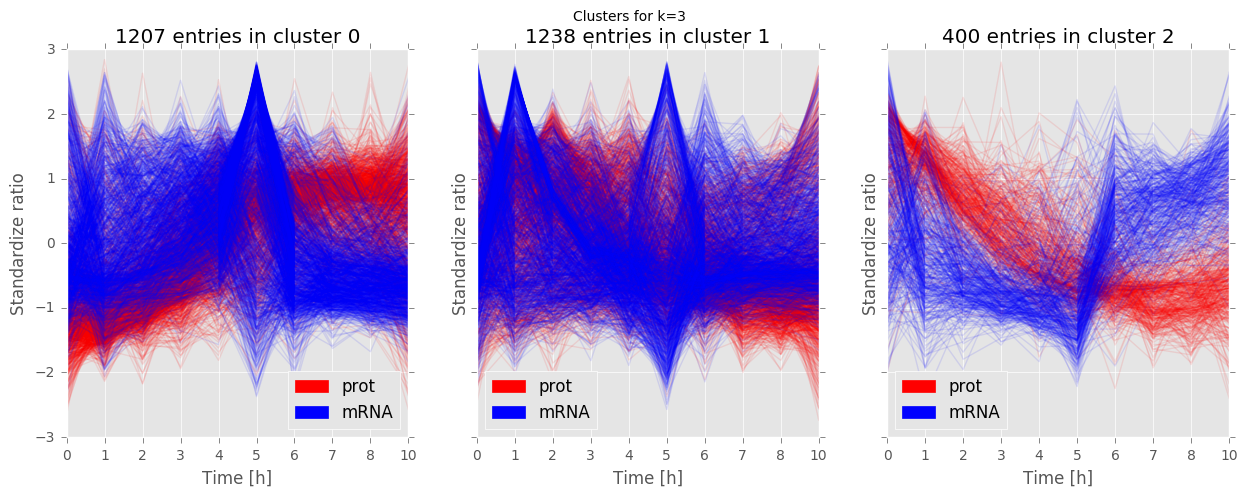

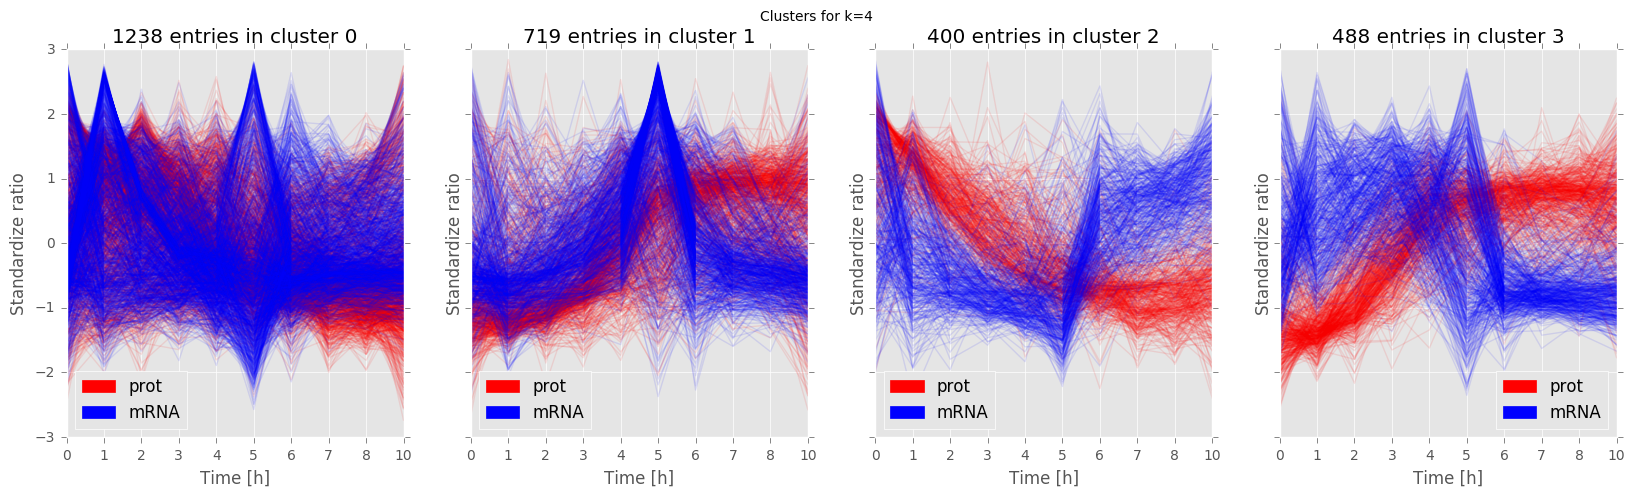

In [19]:
for n_clust in [2, 3, 4]:
        
    f, axarr = plt.subplots(1,n_clust, figsize=(5*n_clust,5), sharey=True)
    f.suptitle('Clusters for k='+str(n_clust))
    
    for k in range(n_clust):
        plot_clust(ward_model[n_clust], prot_data, mRNA_data, k, pos = axarr[k])

        n_entries = np.sum(ward_model[n_clust].labels_ == k)
        axarr[k].set_title(str(n_entries)+' entries in cluster '+str(k))
        axarr[k].set_ylabel('Standardize ratio')
        axarr[k].set_xlabel('Time [h]')
        axarr[k].set_xticklabels([k for k in range(0, 11) if k!= 9])

    plt.show()

For k = 4, the 4 clusters are almost the same than our previous clusters : 
- The levels patterns are the same.
- The number of entries in each cluster can vary a bit :
    - Cluster 1 and cluster 3 contains a similar number of entries.
    - Cluster 0 contains more entries than before
    - Cluster 2 contains less entries than before

It is not surprising to see migrations between clusters as our silhouette score was low (overlapping clusters).<br/>
However :
- Our cluster c0 was regarded as the cluster containing mostly correlated entries
- Our cluster c2 was regarded as the cluster containing mostly uncorrelated entries

Let's check how our histogram of correlation has been modified for k = 4 :

In [20]:
k = [2, 3, 4, 5, 10, 20]
corr_models = {}

for n_clust in k: # For each model with various k
    corr_clust = []
    for l in range(n_clust): # For each cluster in this model
        correl = np.array([])
        for x in np.where(ward_model[n_clust].labels_ == l)[0]: # For each entry corresponding to this cluster
            correl = np.append(correl, [compute_corr(x)])
        
        corr_clust.append(pd.Series(correl, index=data.index[np.where(ward_model[n_clust].labels_ == l)]))
        
    corr_models[n_clust] = corr_clust

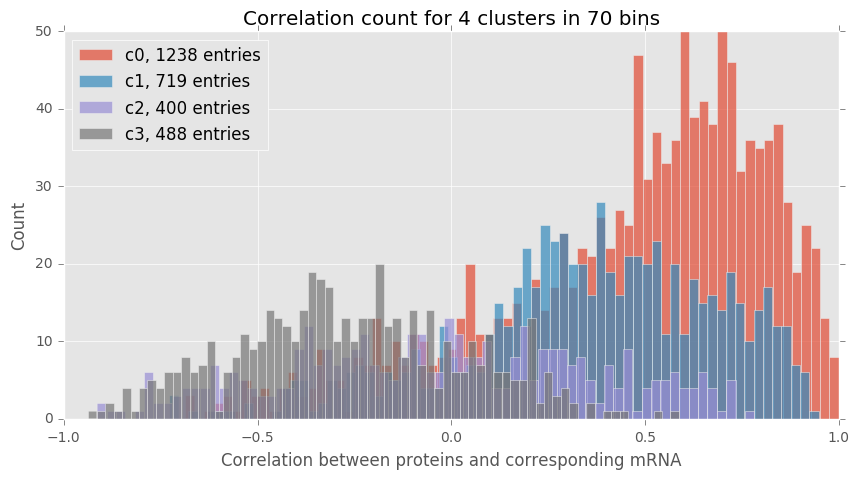

In [21]:
nbins = 70

k_model = 4

plt.figure(figsize=(10,5))

for k in range(k_model):
    plt.hist(corr_models[k_model][k], bins=nbins, label='c'+str(k)+', '+str(len(corr_models[k_model][k]))+' entries', alpha=0.7)
    plt.legend(loc='best')
    plt.title('Correlation count for '+str(k_model)+' clusters in '+str(nbins)+' bins')
    plt.xlabel('Correlation between proteins and corresponding mRNA')
    plt.ylabel('Count')

plt.show()

As expected, c0 contains more non-correlated (and weakly correlated) data than before. Thus, its averaged correlation coefficient passes from 0.563 to 0.463. <br/>
Concerning c2, its averaged correlation coefficient passes from 0.047 to -0.034.

## IV - Bootstrapping

https://en.wikipedia.org/wiki/Bootstrapping_(statistics)

https://en.wikipedia.org/wiki/Bootstrap_aggregating

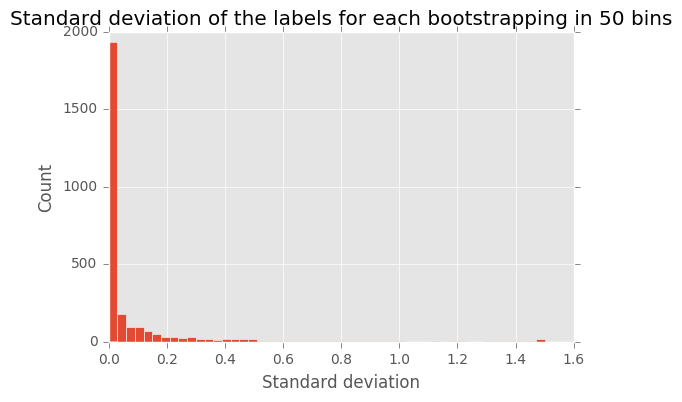

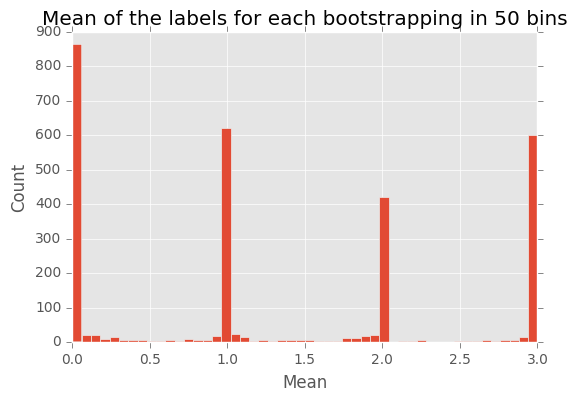

In [26]:
# Choose S from N data entries, M times
M = 2000
S = int(0.8*data.shape[0])
N = data.shape[0]

# Use k-means clustering with 'n_clust' clusters
n_clust = 4

# First k-means
# choose S from N entries
ids = np.random.choice(N, S)

# compute k-means
kmeans_model = KMeans(n_clusters=n_clust)
rel_dist_model_k = kmeans_model.fit(rel_dist_data.iloc[ids])

# save weights
bootst_labels = -np.ones((M,N))
bootst_labels[0,ids] = rel_dist_model_k.labels_

# setup cluster centers
sum_c_centers = rel_dist_model_k.cluster_centers_

# Compute k-means labels for each sub-samples
for k in range(1,M):
    # choose S from N entries
    ids = np.random.choice(N, S)
    
    # compute k-means
    kmeans_model = KMeans(n_clusters=n_clust, init=sum_c_centers/float(k), n_init=1)
    rel_dist_model_k = kmeans_model.fit(rel_dist_data.iloc[ids])
    
    # save weights
    bootst_labels[k,ids] = rel_dist_model_k.labels_
    
    # update c_centers
    sum_c_centers += rel_dist_model_k.cluster_centers_
    
    #if k%10==0:
    #    print('Progress : '+str(k)+' / '+str(M))

# Compute mean and std of m labels available (not -1) for each entries
bootst_labels_means = np.zeros(N)
bootst_labels_stds = np.zeros(N)
for i in range(N):
    bootst_labels_means[i] = bootst_labels[np.where(bootst_labels[:,i] > -1)[0],i].mean()
    bootst_labels_stds[i] = bootst_labels[np.where(bootst_labels[:,i] > -1)[0],i].std()
    
# Plot histogram of standard deviation of the m labels available
nbins = 50
plt.hist(bootst_labels_stds, bins=nbins)
plt.title('Standard deviation of the labels for each bootstrapping in '+str(nbins)+' bins')
plt.xlabel('Standard deviation')
plt.ylabel('Count')
plt.show()

# Plot histogram of mean of the m labels available
nbins = 50
plt.hist(bootst_labels_means, bins=nbins)
plt.title('Mean of the labels for each bootstrapping in '+str(nbins)+' bins')
plt.xlabel('Mean')
plt.ylabel('Count')
plt.show()

### Count and distribution of entries with high bootstrap standard deviation

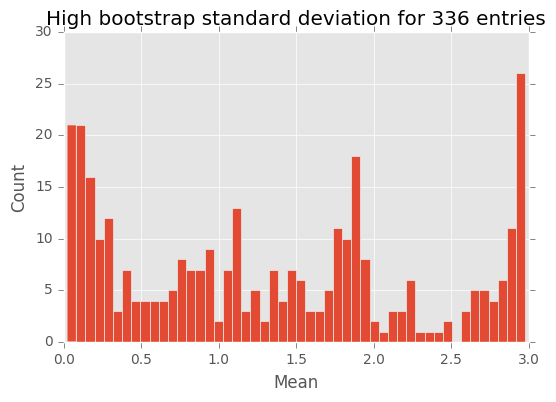

In [27]:
nbins = 50
thr = bootst_labels_stds.std()
plt.hist(bootst_labels_means[bootst_labels_stds > thr], bins=nbins)
plt.title('High bootstrap standard deviation for '+str((bootst_labels_stds > thr).sum())+' entries')
plt.xlabel('Mean')
plt.ylabel('Count')
plt.show()

### Low bootstrap standard deviation

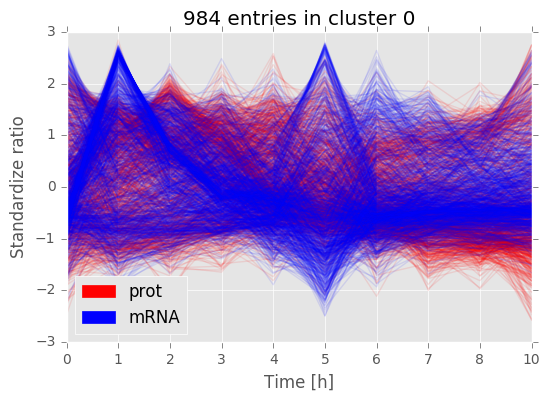

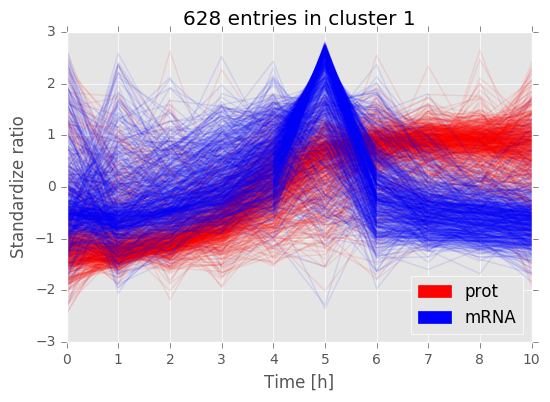

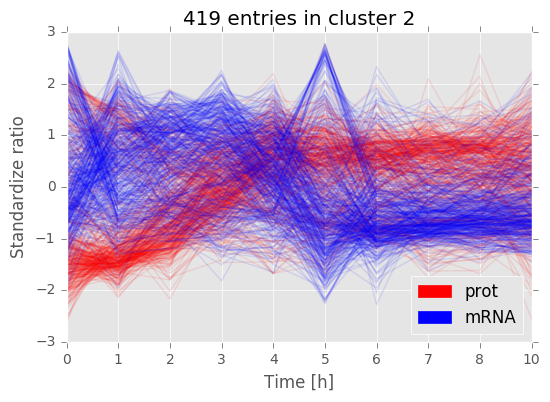

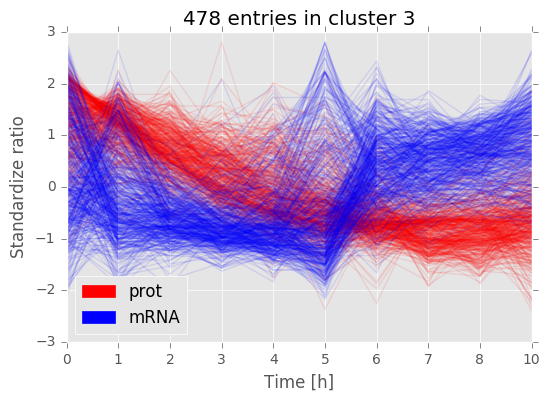

In [28]:
# Threshold parameter
thr = bootst_labels_stds.std()

b_labels = bootst_labels_means.astype(int)
for l in range(n_clust):
    ids = np.where((b_labels == l) & (bootst_labels_stds < thr))[0]
    
    plt.plot(np.arange(10), prot_data.iloc[ids].values.T, color=(1.0,0.0,0.0,0.1))
    plt.plot(np.arange(10), mRNA_data.iloc[ids].values.T, color=(0.0,0.0,1.0,0.1))
    
    red = mpatches.Patch(color='red', label='prot')
    blue = mpatches.Patch(color='blue', label='mRNA')
    plt.legend(handles=[red,blue], loc='best')
    
    n_entries = ids.shape[0]
    plt.title(str(n_entries)+' entries in cluster '+str(l))
    plt.ylabel('Standardize ratio')
    plt.xlabel('Time [h]')
    plt.xticks([k for k in range(0, 10)], [k for k in range(0, 11) if k!= 9])

    plt.show()

## Conclusion 

It seems that uncorrelated mRNA and proteins levels are more likely to follow a particular evolution over time.<br/>
However, we can find uncorrelated levels in each of our clusters. <br/>
Thus, it mights be more reasonable to select uncorrelated entries using a Pearson's correlation coefficient's thresehold rather than our "uncorrelated" cluster.